In [1]:
!pip install -qqq git+https://github.com/chalk-diagrams/chalk git+https://github.com/srush/RASPy 

^C
ERROR: Operation cancelled by user


In [ ]:
from IPython.display import display, HTML
from raspy import key, query, tokens, indices, where, draw
import random

# Transformer Puzzles

This notebook is a collection of short coding puzzles based on the internals of the Transformer. The puzzles are written in Python and can be done in this notebook. After completing these you will have a much better intutive sense of how a Transformer can compute certain logical operations. 

These puzzles are based on [Thinking Like Transformers](https://arxiv.org/pdf/2106.06981.pdf) by Gail Weiss, Yoav Goldberg, Eran Yahav and derived from this [blog post](https://srush.github.io/raspy/).

## Goal

**Can we produce a Transformer that does basic addition?**

i.e. given a string "19492+23919" can we produce the correct output? 

## Rules

Each exercise consists of a function with a argument `seq` and output `seq`. Like a transformer we cannot change length. Operations need to act on the entire sequence in parallel. There is a global `indices` which tells use the position in the sequence. If we want to do something different on certain positions we can use `where` like in Numpy or PyTorch. To run the seq we need to give it an initial input. 

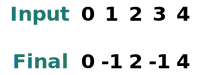

In [2]:
def even_vals(seq=tokens):
    "Keep even positions, set odd positions to -1"
    x = indices % 2
    # Note that all operations broadcast so you can use scalars.
    return where(x == 0, seq, -1)
seq = even_vals()

# Give the initial input tokens
seq.input([0,1,2,3,4])

The main operation you can use is "attention". You do this by defining a selector which forms a matrix based on `key` and `query`.

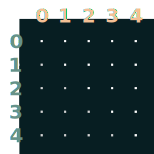

In [3]:
before = key(indices) < query(indices)
before

We can combine selectors with logical operations.

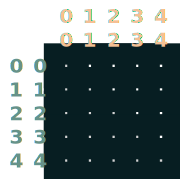

In [4]:
before_or_same = before | (key(indices) == query(indices))
before_or_same

Once you have a selector, you can apply "attention" to sum over the grey positions. For example to compute cumulative such we run the following function. 

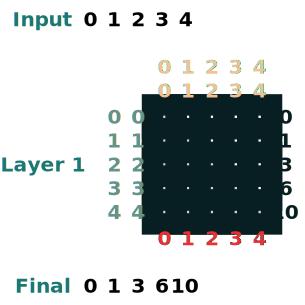

In [5]:
def cumsum(seq=tokens):
    return before_or_same.value(seq)
seq = cumsum()
seq.input([0, 1, 2, 3, 4])

In [6]:
# @title "Test Code Ignore"
def atoi(seq=tokens):
    return seq.map(lambda x: ord(x) - ord('0'))

def test_output(user, spec, token_sets):
    for ex_num, token_set in enumerate(token_sets):        
        out1 = user(*token_set[:-1])((token_set[-1]))
        out2 = spec(*token_set)
        print(f"Example {ex_num}. Args:", token_set, "Expected:", out2)
        display(out1)
        out1 = out1.toseq()
        for i, o in enumerate(out2):
            assert out1[i] == o, f"Output: {out1} Expected: {out2}"

    pups = [
    "2m78jPG",
    "pn1e9TO",
    "MQCIwzT",
    "udLK6FS",
    "ZNem5o3",
    "DS2IZ6K",
    "aydRUz8",
    "MVUdQYK",
    "kLvno0p",
    "wScLiVz",
    "Z0TII8i",
    "F1SChho",
    "9hRi2jN",
    "lvzRF3W",
    "fqHxOGI",
    "1xeUYme",
    "6tVqKyM",
    "CCxZ6Wr",
    "lMW0OPQ",
    "wHVpHVG",
    "Wj2PGRl",
    "HlaTE8H",
    "k5jALH0",
    "3V37Hqr",
    "Eq2uMTA",
    "Vy9JShx",
    "g9I2ZmK",
    "Nu4RH7f",
    "sWp0Dqd",
    "bRKfspn",
    "qawCMl5",
    "2F6j2B4",
    "fiJxCVA",
    "pCAIlxD",
    "zJx2skh",
    "2Gdl1u7",
    "aJJAY4c",
    "ros6RLC",
    "DKLBJh7",
    "eyxH0Wc",
    "rJEkEw4"]
    print("Success!")
    return HTML("""
    <video alt="test" controls autoplay=1>
        <source src="https://openpuppies.com/mp4/%s.mp4"  type="video/mp4">
    </video>
    """%(random.sample(pups, 1)[0]))
SEQ = [2,1,3,2,4]
SEQ2 = [3, 4 ,3, -1, 2]

For each problem we will provide a Python specification. Your goal is to implement that specification with Transformers.

### Challenge 0: Select the initial position

Given a initial sequence compute a new sequence where all positions have the initial value. (1 line)

In [7]:
def head_spec(seq):
    return [seq[0] for _ in seq]

In [8]:
def head(seq=tokens):
    return (key(indices) == query(0)).value(seq)
  

Example 0. Args: ([2, 1, 3, 2, 4],) Expected: [2, 2, 2, 2, 2]


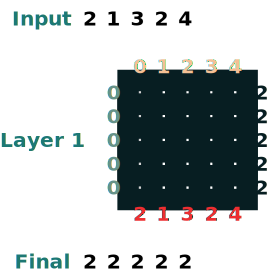

Example 1. Args: ([3, 4, 3, -1, 2],) Expected: [3, 3, 3, 3, 3]


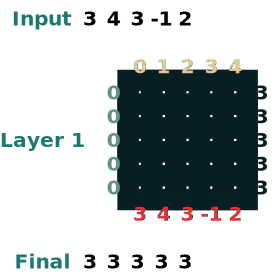

Success!


In [9]:
test_output(head, head_spec, [(SEQ,),(SEQ2,)])

### Challenge 1: Select a given index

Produce a sequence where all the elements have the value at index `i`.

In [10]:
def index_spec(i, seq):
    return [seq[i] for _ in seq]

In [11]:
def index(i, seq=tokens):
    x = (key(indices) == query(i)).value(seq)
    return x.name("index")

Example 0. Args: (2, [2, 1, 3, 2, 4]) Expected: [3, 3, 3, 3, 3]


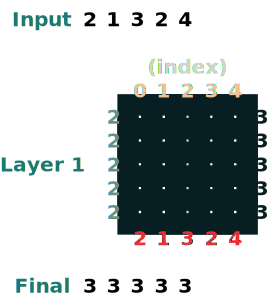

Example 1. Args: (3, [3, 4, 3, -1, 2]) Expected: [-1, -1, -1, -1, -1]


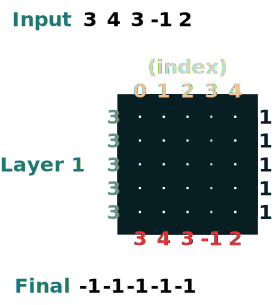

Example 2. Args: (1, [2, 1, 3, 2, 4]) Expected: [1, 1, 1, 1, 1]


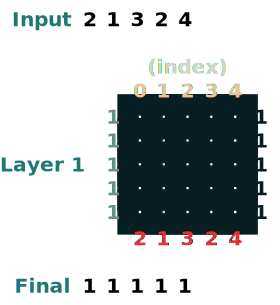

Success!


In [12]:
test_output(index, index_spec, [(2, SEQ), (3, SEQ2), (1, SEQ)])

### Challenge 2: Shift

Shift all of the tokens in a sequence to the right by `i` positions filling in the values with `default`. (1 line)

In [13]:
def shift_spec(i, default="0", seq=None):
    return [default]*i + [s for j, s in enumerate(seq) if j < len(seq) - i]

In [14]:
def shift(i, default="0", seq=tokens):
    x = (key(indices) == query(indices-i)).value(seq, default)
    return x.name("shift")

Example 0. Args: (2, 0, [2, 1, 3, 2, 4]) Expected: [0, 0, 2, 1, 3]


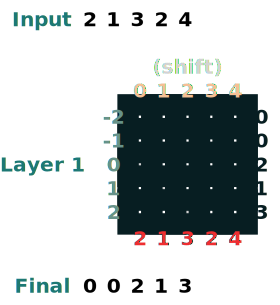

Example 1. Args: (3, 0, [3, 4, 3, -1, 2]) Expected: [0, 0, 0, 3, 4]


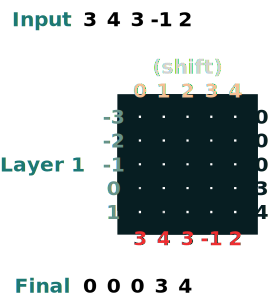

Example 2. Args: (1, 0, [2, 1, 3, 2, 4]) Expected: [0, 2, 1, 3, 2]


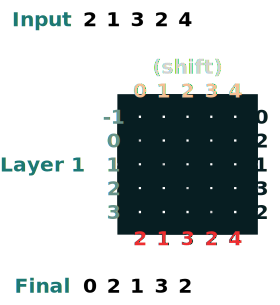

Success!


In [15]:
test_output(shift, shift_spec, [(2, 0, SEQ), (3, 0, SEQ2), (1, 0, SEQ)])

### Challenge 3: Right Align

Right align a padded sequence e.g. ralign().inputs('xyz___') = '000xyz'" (3 layers) (2 lines)

In [16]:
def ralign_spec(ldefault="0", seq=tokens):
    last = None
    for i in range(len(seq)-1, -1, -1):
        if seq[i] == "_":
            last = i
        else:
            break
    if last == None:
        return seq
    return [ldefault] * (len(seq) - last)  + seq[:last]

In [17]:
def ralign(ldefault="0", seq=tokens):
    c = (key(seq) == query("_")).value(1)
    return (key(indices + c) == query(indices)).value(seq, ldefault)

Example 0. Args: ('-', ['x', 'y', 'z', 'a', 'b', 'c', '_', '_']) Expected: ['-', '-', 'x', 'y', 'z', 'a', 'b', 'c']


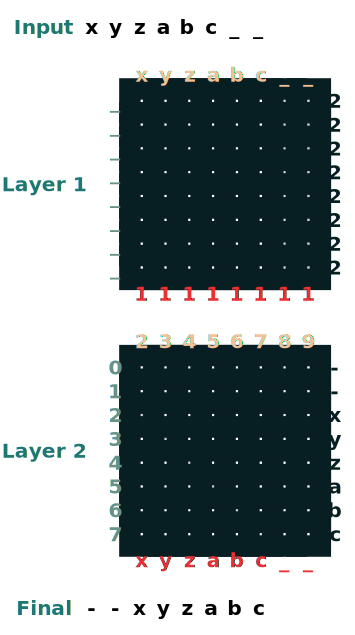

Example 1. Args: ('0', ['x', 'y', 'z', '_', '_', '_']) Expected: ['0', '0', '0', 'x', 'y', 'z']


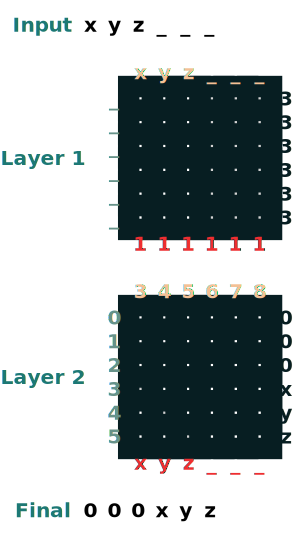

Success!


In [18]:
test_output(ralign, ralign_spec, [("-", list("xyzabc__"),), ("0", list("xyz___"),)])

### Challenge 4: Split

Split a sequence on a value. Get the first or second part. Right align. (5 lines)

In [19]:
def split_spec(v, get_first_part, seq):
    out = []
    mid = False
    blank = "0" if not get_first_part else "_"
    for j, s in enumerate(seq):
        if s == v:
            out.append(blank)
            mid = True
        elif (get_first_part and not mid) or (not get_first_part and mid):
            out.append(s)
        else:
            out.append(blank)
    return ralign_spec("0", seq=out)

In [20]:
def split(v, get_first_part, seq=tokens):
    split_point = (key(seq) == query(v)).value(indices)
    if get_first_part:
        x = ralign("0", seq=where(indices < split_point, 
                             seq, "_"))
        return x
    else:
        x = where(indices > split_point, seq, "0")
        return x

Example 0. Args: ('-', 1, ['x', 'y', 'z', '-', 'a', 'x']) Expected: ['0', '0', '0', 'x', 'y', 'z']


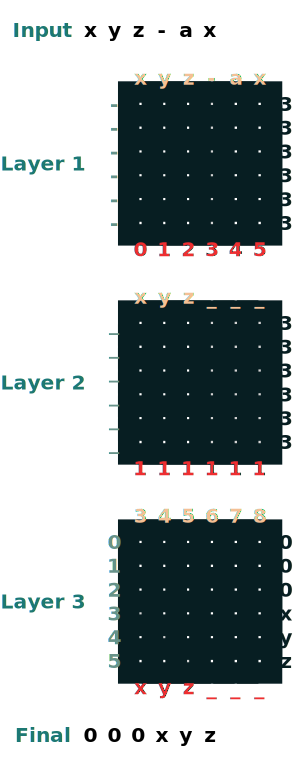

Example 1. Args: ('-', 0, ['x', 'y', 'z', '-', 'a', 'x']) Expected: ['0', '0', '0', '0', 'a', 'x']


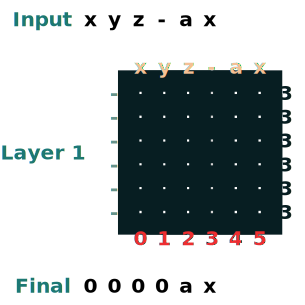

Example 2. Args: ('+', 0, ['x', 'y', '+', 'z', '-', 'a', 'x']) Expected: ['0', '0', '0', 'z', '-', 'a', 'x']


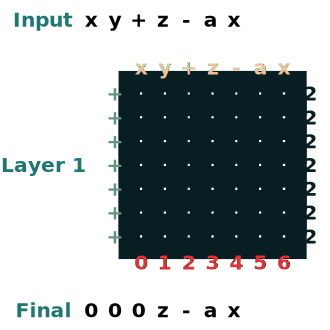

Success!


In [21]:
test_output(split, split_spec,
            [("-", 1, list("xyz-ax"),),
             ("-", 0, list("xyz-ax"),),
             ("+", 0, list("xy+z-ax"),)]
             )

### Challenge 5: Minimum 

Compute the minimum value of the sequence. This one starts to get harder! (5 lines of code)

In [22]:
def minimum_spec(seq):
    m = min(seq)
    return [m for _ in seq]

In [23]:
def minimum(seq=tokens):
    before = key(indices) < query(indices)
    sel1 = before & (key(seq) == query(seq))
    sel2 = key(seq) < query(seq)
    less = (sel1 | sel2).value(1)
    x = (key(less) == query(0)).value(seq)
    return x

Example 0. Args: ([2, 1, 3, 2, 4],) Expected: [1, 1, 1, 1, 1]


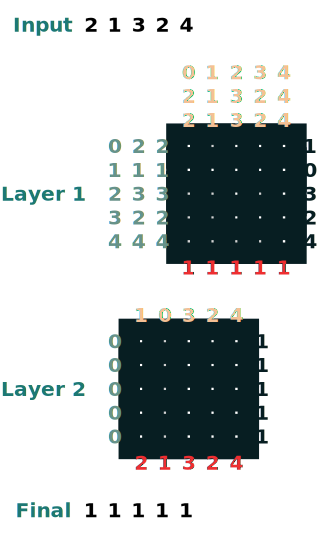

Example 1. Args: ([3, 4, 3, -1, 2],) Expected: [-1, -1, -1, -1, -1]


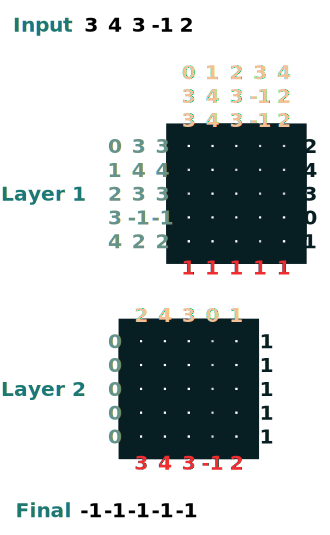

Example 2. Args: ([2, 1, 1],) Expected: [1, 1, 1]


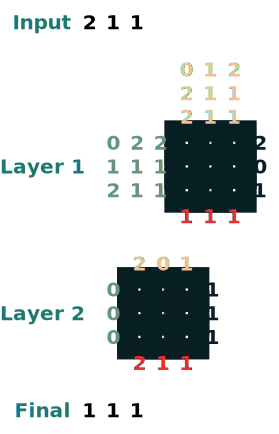

Success!


In [24]:
test_output(minimum, minimum_spec, [(SEQ,), (SEQ2,), ([2, 1, 1],)])

### Challenge 6: First Index

Compute the first index that has token `token`. (1 line)

In [25]:
def first_spec(token, seq):
    first = None
    for i, s in enumerate(seq):
        if s == token:
            first = i
    return [first for _ in seq]

In [26]:
def first(token, seq=tokens):
    return minimum(where(seq == token, indices, 99))

Example 0. Args: (3, [2, 1, 3, 2, 4]) Expected: [2, 2, 2, 2, 2]


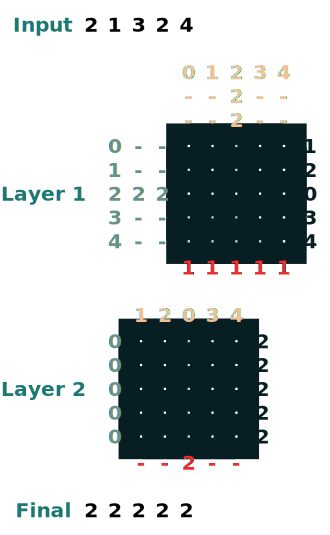

Example 1. Args: (-1, [3, 4, 3, -1, 2]) Expected: [3, 3, 3, 3, 3]


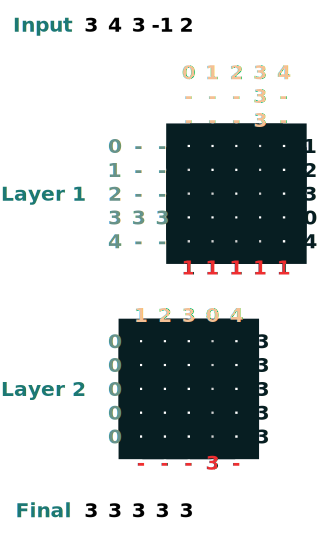

Success!


In [27]:
test_output(first, first_spec, [(3, SEQ), (-1, SEQ2)])

### Challenge 7: Slide

Replace special tokens "<" with the closest non "<" value to their right. (4 lines of code)

In [28]:
def slide_spec(match, seq):
    out = []
    for i, s in enumerate(seq):
        if s == "<":
            for v in seq[i+1:]:
                if v != "<":
                    out.append(v)
                    break
        else:
            out.append(s)
    return out

In [29]:
def slide(match="<", seq=tokens):
    match = seq != "<" 
    x = cumsum(match) 
    y = ((key(x) == query(x + 1)) & (key(match) == query(True))).value(seq)
    seq =  where(match, seq, y)
    return seq.name("slide")

Example 0. Args: ('<', ['1', '<', '<', '2']) Expected: ['1', '2', '2', '2']


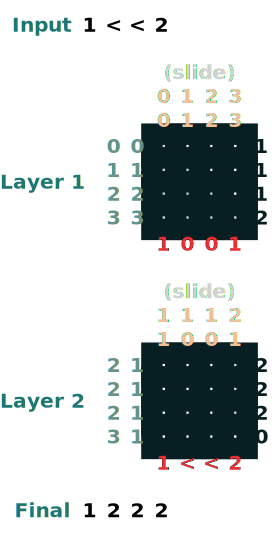

Example 1. Args: ('<', ['2', '<', '<', '<', '3']) Expected: ['2', '3', '3', '3', '3']


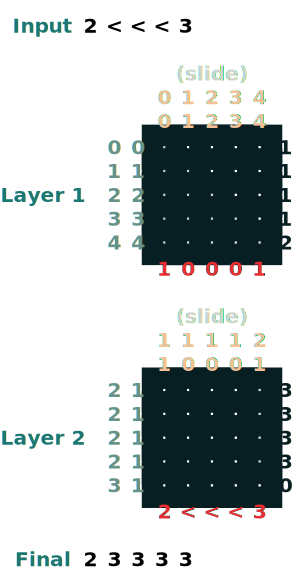

Example 2. Args: ('<', ['3', '<', '<', '<', '1', '<', '<', '3']) Expected: ['3', '1', '1', '1', '1', '3', '3', '3']


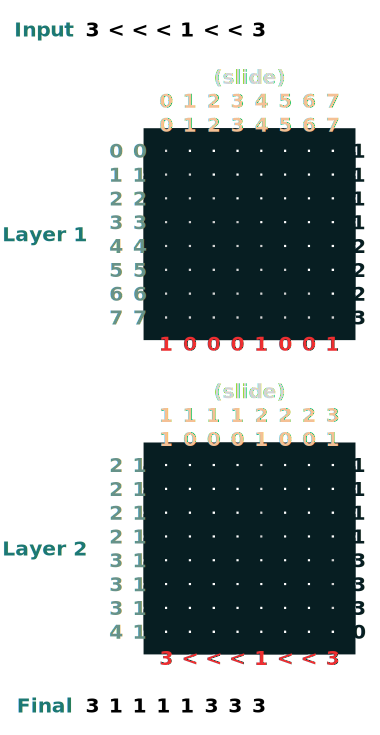

Success!


In [30]:
test_output(slide, slide_spec,
            [("<",  list("1<<2"),),
             ("<",  list("2<<<3"),),
             ("<",  list("3<<<1<<3"),)]
             )

### Final Challenge: Adder

Now we will put everything together. Here are the steps. 

add().input("683+345")

0) Split into parts. Convert to ints. Add

> "683+345" => [0, 0, 0, 9, 12, 8]

1) Compute the carry terms. Three possibilities: 1 has carry, 0 no carry, < maybe has carry. 

> [0, 0, 0, 9, 12, 8] => "00<100"

2) Slide the carry coefficients

> "00<100" => 001100"

3) Complete the addition.

Each of these is 1 line of code. 

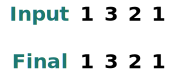

In [31]:
# The function atoi lets us convert from string to sequences of integers
atoi(tokens).input("1321")

In [32]:
def add_spec(seq):
    a, b = "".join(seq).split("+")
    c = int(a) + int(b)
    out = f"{c}"
    return list(map(int, list(("0" * (len(seq) - len(out))) + out)))

In [33]:
def add(seq=tokens):
    x = atoi(split("+", True, seq)) \
        + atoi(split("+", False, seq))
    # 1) Check for carries 
    gets_carry = shift(-1, "0", where(x > 9, "1", where(x == 9, "<", "0")))
    # 2) Slide carries to their columns - all in one parallel go!                                         
    gets_carry = atoi(slide("<", gets_carry))
    # 3) Add in carries, and remove overflow from original addition.                                                                               
    return (x + gets_carry) % 10

Example 0. Args: (['1', '+', '2'],) Expected: [0, 0, 3]


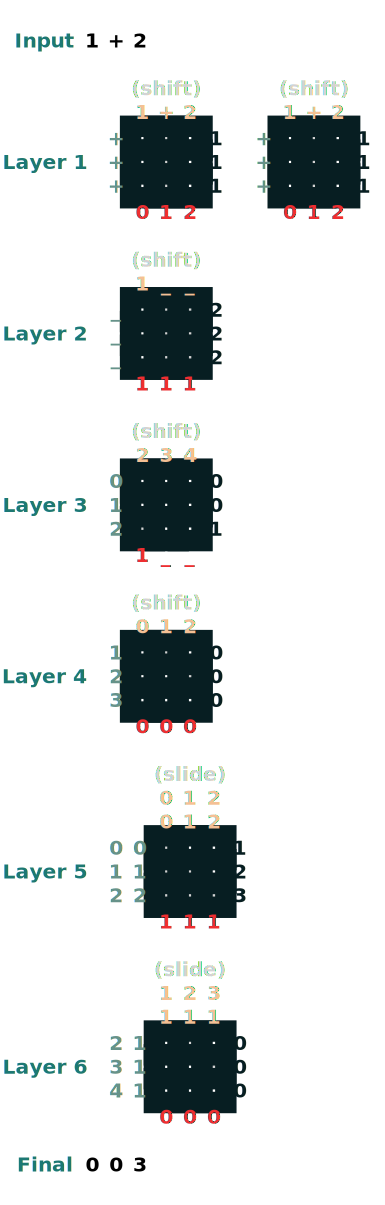

Example 1. Args: (['2', '2', '+', '3', '8', '4'],) Expected: [0, 0, 0, 4, 0, 6]


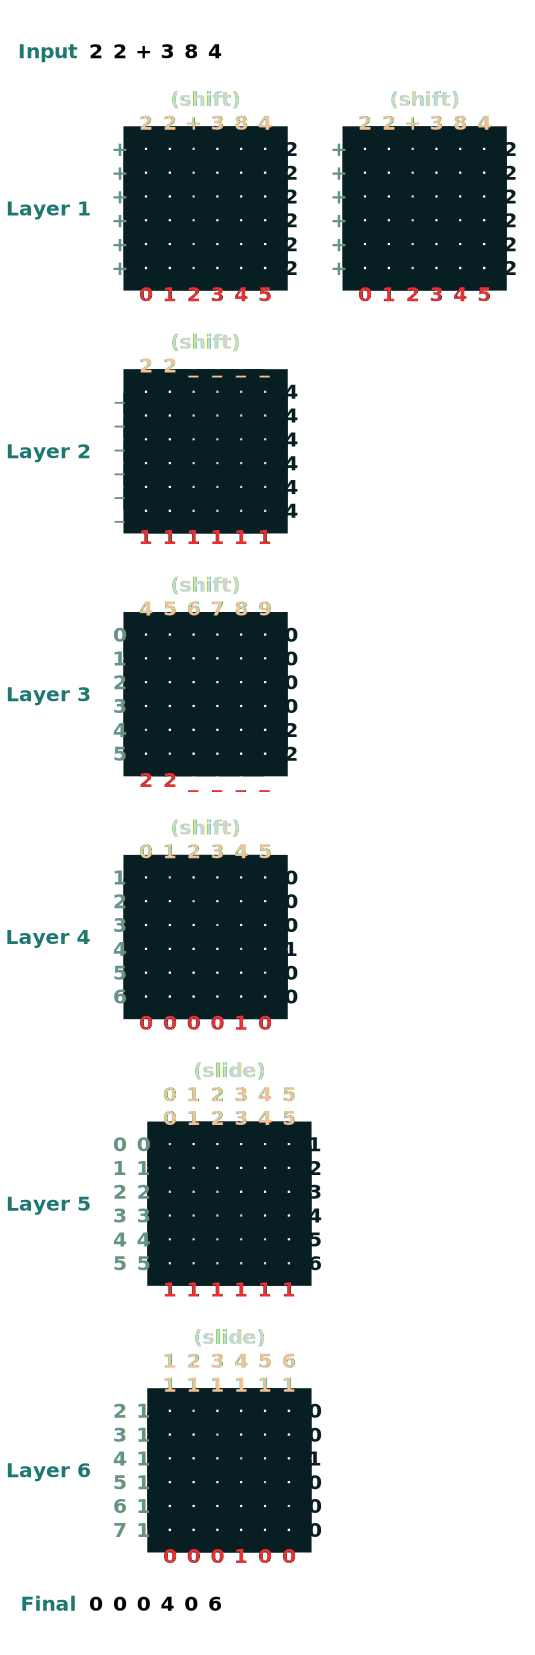

Example 2. Args: (['3', '+', '1', '0'],) Expected: [0, 0, 1, 3]


In [ ]:
test_output(add, add_spec,
            [(list("1+2"),),
             (list("22+384"),),
             (list("3+10"),)]
             )